In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprompt and grammar

In [3]:
with open("../benchmark/grammars/us_lpm_grammar.lark", "r") as f:
    grammar = f.read()

In [4]:
def make_preamble(constructor):
    return f"""Your goal is to translate user questions into conditional probability statements relating the variables mentioned in the query.


Statements should take the form "{constructor('X','Y')}" where X is one of the following variables and Y one or a list of multiple variables. The grammar used is the following:

```
{grammar}
```

The variables X and Y should be closely related to the entities mentioned in the user query.

Here are some examples of user queries and paired translations:

"""

def make_prompt(preamble, example_pairs, eos=None):
    examples = '\n\n'.join([f"Q: {nl}\nA: {fl}{f' {eos}' if eos is not None else ''}" for (nl,fl) in example_pairs]) + "\n\nQ: {user_query}\nA:"
    return preamble + examples  

def make_example_pairs(constructor):
    return [
        ("How does someone's age affect their income?", 
         constructor("Total_income", ["Age"])),
        ("How does someone's credit rating affect whether or not they are conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Credit_rating"])),
        ("How does someone's credit rating and race affect whether or not they are conservative? ", 
         constructor("Political_ideology = 'Likely Conservative'", ["Credit_rating", "Race"])),
         ("How does the probability that someone is conservative change by income?",
           constructor("Political_ideology = 'Likely Conservative'", ["Total_income"])),
    ]

constructor = lambda event, conditioners : f"probability of {event} given {', '.join(conditioners)}"

pre_prompt = make_prompt(
    preamble=make_preamble(constructor), 
    example_pairs=make_example_pairs(constructor), 
    eos=None
)

# Test cases

In [5]:
def make_test_cases(constructor):
    return [
        ("How does someone's education affect their credit rating?", 
         constructor("Credit_rating", ["Education"])),
        ("What's the relationship between someone's income and how likely they are to be conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Total_income"])),
        ("What's the relationship between someone's income and religiosity how likely they are to be conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Total_income", "Religious_inspiration"])),
        ("What's the relationship between someone's income and race how likely they are to be conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Total_income", "Race"])),
        ("What's the relationship between someone's income and their commute time?", 
         constructor("Commute_minutes", ["Total_income"])),
        ("How does the probability that someone has no commute time change with age?", 
         constructor("Commute_minutes = '(a) no commute'", ["Age"]))
    ]

import re

def normalize_string(string):
    return re.sub(r'^\s+', '', re.sub(r"▪|</s>", '', string))

def are_equal_up_to_ws(str1, str2):
    return re.sub(r'\n|\s+', '', str1) == re.sub(r'\n|\s+', '', str2)

In [6]:
test_cases = make_test_cases(constructor)

# Inference

In [7]:
from genparse.util import lark_guide
# two guides to isolate caches
guide_s = lark_guide(grammar)
guide_p = lark_guide(grammar)

from genparse.experimental.batch_inference import BatchVLLM
batch_llm = BatchVLLM.from_name('meta-llama/Meta-Llama-3-8B')

/home/lebrunb/miniconda3/envs/genparse3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-25 02:22:53,488	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 07-25 02:22:59 llm_engine.py:161] Initializing an LLM engine (v0.5.0.post1) with config: model='meta-llama/Meta-Llama-3-8B', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=meta-llama/Meta-Llama-3-8B)
INFO 07-25 02:23:00 weight_utils.py:218] Using model weights format ['*.safetensors']
INFO 07-25 02:23:05 model_runner.py:160] Loading model weights took 14.9595 GB
INFO 07-25 02:23:07 gpu_executor.py:83] # GPU blocks: 9638, # CPU blocks: 2048
INFO 07-25 02:23:09 model_runner.p

In [8]:
from genparse.experimental.batch_inference import ParallelCharacterProposal, CharacterBatchProposal
import multiprocessing as mp

parallel_proposal = ParallelCharacterProposal(
    llm=batch_llm.llm, guide=guide_p, num_processes=mp.cpu_count(), max_n_particles=350, seed=0
)

sequential_proposal = CharacterBatchProposal(llm=batch_llm.llm, guide=guide_s)

Initialized parallel batch proposal with num_processes=12, max_n_particles=350, seed=0


In [9]:
from genparse.experimental.batch_inference import BatchStepModel
parallel_step_model = BatchStepModel(batch_proposal=parallel_proposal, batch_llm=batch_llm, max_tokens=50)
sequential_step_model = BatchStepModel(batch_proposal=sequential_proposal, batch_llm=batch_llm, max_tokens=50)

Initialized batch stepper with eos=▪ and max_tokens=50
Initialized batch stepper with eos=▪ and max_tokens=50


In [15]:
from genparse.util import set_seed
set_seed(0)

In [20]:
from genparse.experimental.batch_inference import smc
parallel_step_model.set_prompt(pre_prompt.format(user_query="How does someone's age affect their income?"))
parallel_approx = smc(parallel_step_model, n_particles=100)
parallel_approx

key,value
probability of Total_income given Age ▪,0.9947034283273442
"probability of Total_income = '(d) $20,000 - $24,999' given Age ▪",0.001298571064963097
probability of Total_income given Age = 35 ▪,0.0011702060437520226
probability of Total_income given Age = 29 ▪,0.001151873191007526
probability of Total_income given Age = 19 ▪,0.001104290687282067
"probability of Total_income = '(b) $10,000 - $14,999' given Age ▪",0.0003305216332708291
probability of Insurance_health_private given Age ▪,0.00023615397432350373
"probability of Total_income = '(e) $25,000 - $29,999' given Age ▪",4.941593586506502e-06
"probability of Total_income = '(g) $35,000 - $39,999' given Age ▪",1.348447027059239e-08


In [21]:
from genparse.experimental.batch_inference import smc
sequential_step_model.set_prompt(pre_prompt.format(user_query="How does someone's age affect their income?"))
sequential_approx = smc(sequential_step_model, n_particles=100)
sequential_approx

key,value
probability of Total_income given Age ▪,0.9815166786261798
probability of Total_income given Total_income ▪,0.01020067194021138
probability of Total_income given Age = 45 ▪,0.0012593717588915154
probability of Total_income given Age = 74 ▪,0.001213464858118819
probability of Total_income given Age = 24 ▪,0.00118573327703555
probability of Total_income given Age = 19 ▪,0.001128109418631137
probability of Total_income given Age = 52 ▪,0.0010867661427620323
probability of Total_income given Age = 22 ▪,0.0010620912274772153
probability of Total_income given Age = 55 ▪,0.0010107371356169008
probability of Insurance_Medicare given Age ▪,0.00019162319385240454


In [26]:
assert sequential_approx.posterior.argmax() == parallel_approx.posterior.argmax()

# Benchmarking

In [27]:
from arsenal.timer import Benchmark

n_processes = parallel_step_model.batch_proposal.num_processes

T = Benchmark(f'Parallel vs Sequential run time on question/answering demo test cases\n (smc, {n_processes=}, character proposal, Llama 3)')

for n_particles in [10, 20, 40, 80, 160, 320]:

    for i, (test_case, _) in enumerate(test_cases):
        parallel_step_model.set_prompt(pre_prompt.format(user_query=test_case))
        sequential_step_model.set_prompt(pre_prompt.format(user_query=test_case))

        with T['parallel proposal'](i=i, n_particles=n_particles):
            parallel_approx = smc(parallel_step_model, n_particles=n_particles)

        with T['sequential proposal'](i=i, n_particles=n_particles):
            sequential_approx = smc(sequential_step_model, n_particles=n_particles)

        want = parallel_approx.posterior.argmax()
        have = sequential_approx.posterior.argmax()

        if not want == have:
            print(repr(test_case), n_particles, repr(want), repr(have))


"What's the relationship between someone's income and religiosity how likely they are to be conservative?" 10 " probability of Political_ideology = 'Likely Conservative' given Total_income, Religious_contributor\n▪" " probability of Political_ideology = 'Likely Conservative' given Total_income, Religious_inspiration\n▪"
"What's the relationship between someone's income and their commute time?" 10 ' probability of Commute_minutes given Total_income\n▪' ' probability of Total_income given Commute_minutes\n▪'
"What's the relationship between someone's income and religiosity how likely they are to be conservative?" 20 " probability of Political_ideology = 'Likely Conservative' given Total_income, Religious_contributor\n▪" ' probability of Religious_contributor given Total_income\n▪'
'How does the probability that someone has no commute time change with age?' 20 " probability of Commute_minutes = '(a) no commute' given Age\n▪" " probability of Means_of_transportation = 'Drove alone' given A

<Axes: title={'center': 'Parallel vs Sequential run time on question/answering demo test cases\n (smc, n_processes=12, character proposal, Llama 3)'}, xlabel='n_particles', ylabel='time (seconds)'>

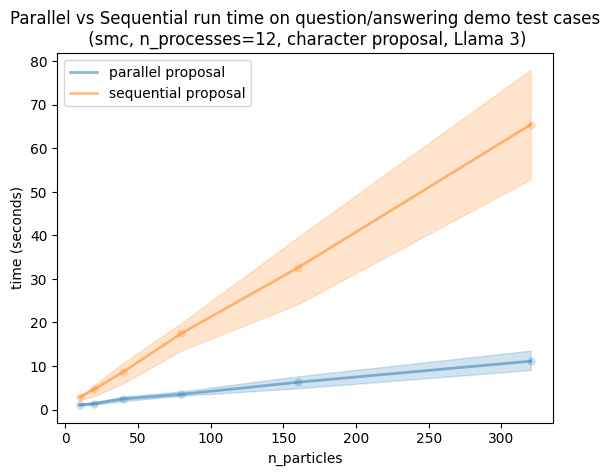

In [29]:
T.plot_feature('n_particles')